In [21]:
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

In [22]:
## Load pickled data
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [23]:
## basic info of data sets
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


1


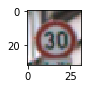

In [24]:
## visualization for image

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [25]:
## LE-Net architechure
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. 
    # out_height = (32 - 5 + 1)/1 = 28,
    # out_width = (32 - 5 + 1)/1 = 28,
    # out_depth = 6(tunned)
    # Output = 28 * 28 * 6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. 
    # out_height = (28 - 2 + 2)/2 = 14,
    # out_width = (28 - 2 + 2)/2 = 14,
    # out_depth = 6(handed by conv1)
    # Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. 
    # out_height = (14 - 5 + 1)/1 = 10,
    # out_width = (14 - 5 + 1)/1 = 10,
    # out_depth = 16(tunned)
    # Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. 
    # out_height = (10 - 2 + 2)/2 = 5,
    # out_width = (10 - 2 + 2)/2 = 5,
    # out_depth = 16(handed by conv2)
    # Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16.
    # Output = 5 * 5 * 16 = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [26]:
## super-parameters
rate = 0.001
EPOCHS = 10
BATCH_SIZE = 64

## TF logic for optimization 
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## TF logic for evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## training/evaluation
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.809

EPOCH 2 ...
Validation Accuracy = 0.862

EPOCH 3 ...
Validation Accuracy = 0.877

EPOCH 4 ...
Validation Accuracy = 0.880

EPOCH 5 ...
Validation Accuracy = 0.896

EPOCH 6 ...
Validation Accuracy = 0.901

EPOCH 7 ...
Validation Accuracy = 0.900

EPOCH 8 ...
Validation Accuracy = 0.913

EPOCH 9 ...
Validation Accuracy = 0.895

EPOCH 10 ...
Validation Accuracy = 0.892

Model saved


In [27]:
## prediction on test
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.885


In [46]:
## analysis with top-k softmax probabilities
import sys,os

softmax = tf.nn.softmax(logits)

k = 5
num_examples = len(X_test)
print(num_examples)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_test[offset:offset+BATCH_SIZE]
        if(offset == 0):
            pred_y = sess.run(softmax, feed_dict={x: batch_x})
        else:
            pred_y = np.vstack([pred_y, sess.run(softmax, feed_dict={x: batch_x})])
    topk = sess.run(tf.nn.top_k(tf.constant(pred_y), k= k))
    
    ## top-k softmax value
    print(topk.values[:50])
    
    flattened_topk = topk.indices.reshape(1, -1).tolist()[0]
    pred_dist = dict((i, 0.0) for i in range(43))
    for v in flattened_topk:
        pred_dist[v] += (1.0/num_examples)
    encoded_y = sess.run(one_hot_y, feed_dict= {y: y_test})
    y_dist = (1.0 * np.sum(encoded_y, axis= 0))/num_examples
    print('\nDistribution for top-%s: ' % k)
    print([round(pred_dist[k], 4) for k in pred_dist])
    
    print('\nDistribution for truth: ')
    print([round(v, 4) for v in y_dist])

12630
INFO:tensorflow:Restoring parameters from ./lenet
[[  1.00000000e+00   5.74623416e-26   1.21370478e-27   1.65265204e-28
    1.92243318e-29]
 [  1.00000000e+00   5.45113390e-15   5.91565746e-16   3.01576684e-17
    2.05050099e-19]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+00   1.28475798e-11   1.27407678e-15   1.29679664e-19
    3.37862065e-24]
 [  1.00000000e+00   1.83112512e-08   4.81564701e-12   3.08051355e-13
    6.08143771e-14]
 [  1.00000000e+00   5.69072802e-30   3.33321812e-36   8.12095564e-38
    0.00000000e+00]
 [  1.00000000e+00   2.81002508e-19   3.15331508e-27   6.30080694e-33
    3.72345405e-37]
 [  1.00000000e+00   5.53925836e-15   2.17251494e-17   2.33253611e-19
    6.83981884e-20]
 [  1.00000000e+00   1.24404861e-10   1.39776848e-15   5.28077232e-18
    4.10112343e-18]
 [  1.00000000e+00   1.87596490e-16   7.60200955e-21   2.89271223e-23
    5.78702444e-24]
 [  9.28750396e-01   6.93784952e-02   1.6843